In [1]:
!pip install -q gdown --no-use-pep517

In [3]:
!pip install tensorflow_hub

In [4]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### About the dataset

We will use BARD (Bangla Article Dataset) which has around 3,76,226 articles collected from different Bangla news portals and labelled with 5 categories : economy, state, international, sports and entertainment.

In [5]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [7]:
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0  840M    0 35719    0     0  15014      0 16:18:16  0:00:02 16:18:14 15014
  0  840M    0 1672k    0     0   543k      0  0:26:23  0:00:03  0:26:20  543k
  0  840M    0 5846k    0     0  1416k      0  0:10:07  0:00:04  0:10:03 1415k
  1  840M    1 13.3M    0     0  2700k      0  0:05:18  0:00:05  0:05:13 2774k
  2  840M    2 21.6M    0     0  3627k      0  0:03:57  0:00:06  0:03:51 5107k
  2  840M    2 24.9M    0     0  3615k      0  0:03:58  0:00:07  0:03:51 5439k
  3  840M    3 27.9M    0     0  3544k      0  0:04:02  0:00:08  0:03:54 5392k
  3  840M    3 30.9M    0     0  3491k      0  0:04

In [8]:
! curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py

 51  840M   51  433M    0     0  4570k      0  0:03:08  0:01:37  0:01:31 5161k
 51  840M   51  436M    0     0  4559k      0  0:03:08  0:01:38  0:01:30 4403k
 52  840M   52  440M    0     0  4547k      0  0:03:09  0:01:39  0:01:30 4421k
 52  840M   52  444M    0     0  4545k      0  0:03:09  0:01:40  0:01:29 4554k
 53  840M   53  451M    0     0  4577k      0  0:03:08  0:01:41  0:01:27 4970k
 54  840M   54  455M    0     0  4568k      0  0:03:08  0:01:42  0:01:26 4537k
 54  840M   54  459M    0     0  4561k      0  0:03:08  0:01:43  0:01:25 4614k
 55  840M   55  463M    0     0  4556k      0  0:03:08  0:01:44  0:01:24 4719k
 55  840M   55  469M    0     0  4577k      0  0:03:08  0:01:45  0:01:23 5222k
 56  840M   56  474M    0     0  4577k      0  0:03:07  0:01:46  0:01:21 4588k
 56  840M   56  478M    0     0  4571k      0  0:03:08  0:01:47  0:01:21 4636k
 57  840M   57  482M    0     0  4567k      0  0:03:08  0:01:48  0:01:20 4684k
 58  840M   58  488M    0     0  4581k      0  0:03:

In [9]:
!python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2020-08-22 16:51:43.245297: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_101.dll
2020-08-22 16:52:09.292125: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2020-08-22 16:52:10.678153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 computeCapability: 6.1
coreClock: 1.733GHz coreCount: 10 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 178.99GiB/s
2020-08-22 16:52:10.678909: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_101.dll
2020-08-22 16:52:10.745748: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_10.dll
2020-08-22 16:52:10.806922: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cufft64_10.dll
20

In [10]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

The text embedding module takes a batch of sentences in a 1D tensor of strings as input and outputs the embedding vectors of shape (batch_size, embedding_dim) corresponding to the sentences. It preprocesses the input by splitting on spaces. For demonstration we pass a list of Bangla words as input and get the corresponding embedding vectors.

In [11]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক']) 

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

## Convert to Tensorflow Dataset

In [16]:
dir_names = ['bard/economy', 'bard/sports', 'bard/entertainment', 'bard/state', 'bard/international']

file_paths = []
labels = []
for i, dir in enumerate(dir_names):
    file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
    file_paths += file_names
    labels += [i] * len(os.listdir(dir))
    
np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

In [17]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

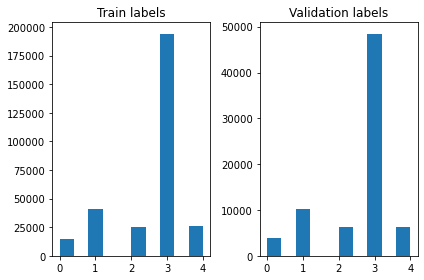

In [18]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

In [19]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [20]:
def make_datasets(train_size):
    batch_size = 256

    train_files = file_paths[:train_size]
    train_labels = labels[:train_size]
    train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
    train_ds = train_ds.map(load_file).shuffle(5000)
    train_ds = train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    test_files = file_paths[train_size:]
    test_labels = labels[train_size:]
    test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
    test_ds = test_ds.map(load_file)
    test_ds = test_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


    return train_ds, test_ds

In [21]:
train_data, validation_data = make_datasets(train_size)

In [22]:
def create_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
    ])
    model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
    return model

In [23]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [26]:
history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=1, 
                    callbacks=[early_stopping_callback])

1176/1176 [==============================] - 1238s 1s/step - loss: 0.1390 - accuracy: 0.9509 - val_loss: 0.1331 - val_accuracy: 0.9521


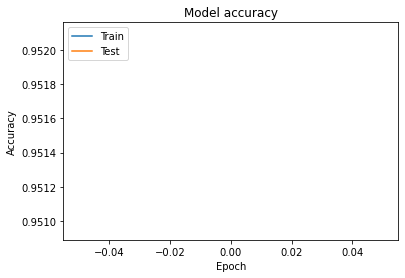

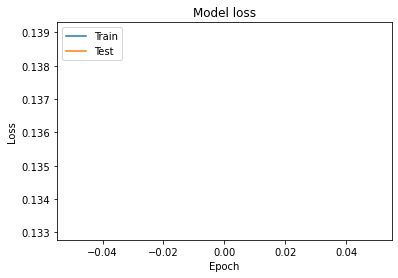

In [31]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [32]:
y_pred = model.predict(validation_data)

In [33]:
y_pred = np.argmax(y_pred, axis=1)

In [34]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
    f = open(sample)
    text = f.read()
    print(text[0:100])
    print("True Class: ", sample.split("/")[0])
    print("Predicted Class: ", dir_names[y_pred[i]])
    f.close()

UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 21: character maps to <undefined>

In [ ]:
y_true = np.array(labels[train_size:])

In [ ]:
print(classification_report(y_true, y_pred, target_names=dir_names))